### Importing packages

In [1]:
import pickle
import datetime
from scipy import stats
from tqdm import tqdm
import pandas as pd
import numpy as np
import vectorbt as vbt
import statsmodels.api as sm
from itertools import combinations, chain
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Helper functions

In [2]:
%run "../utils/functions.py"

### Load data

In [3]:
with open(
    file="../data/coin_px_vol_2022-06-24_to_2025-06-24.pkl", 
    mode="rb"
    ) as f:
    data_dict = pickle.load(f)

coin_prices = pd.concat(
    [
        data_dict[i]["price"] for i in data_dict
    ],
    axis=1
)

coin_prices.columns = [i for i in data_dict]

coin_prices = coin_prices.dropna(
    axis = 1,
    thresh = 0.99 * coin_prices.shape[0]
).ffill(limit=2).replace(np.nan, 0)

print(
    f"Crypto data from {str(coin_prices.index.min().date())} to {str(coin_prices.index.max().date())}"
    )

coin_prices.tail(4)

Crypto data from 2022-06-25 to 2025-06-24


,SOL,BTC,XRP,DOGE,ETH,ADA,BNB,TRX,AAVE,UNI,...,BICO,FIST,GMX,BAND,LRC,RARE,SKL,TWT,HNT,PHB
date,,,,,,,,,,,,,,,,,,,,,
2025-06-21,140.061295,103290.105145,2.120113,0.162332,2403.607721,0.576848,641.466075,0.272483,247.264404,7.073481,...,0.089715,0.321726,14.070058,0.584629,0.075146,0.048383,0.017951,0.722245,2.428924,0.414596
2025-06-22,133.866437,101532.568385,2.044380,0.153080,2277.899190,0.550708,626.568767,0.270289,231.713187,6.388992,...,0.085296,0.437483,13.186598,0.550390,0.071409,0.044991,0.016872,0.684994,2.251220,0.385577
2025-06-23,132.210728,100852.582646,2.013513,0.151148,2229.907577,0.541130,615.920084,0.263612,227.555713,6.260848,...,0.082184,0.434130,12.899459,0.520715,0.069055,0.043732,0.016632,0.669218,2.171437,0.374358
2025-06-24,144.786261,105511.624379,2.164008,0.164473,2422.994920,0.583240,640.254318,0.273023,258.018653,6.830906,...,0.093872,0.448770,14.122592,0.588557,0.077711,0.048367,0.018450,0.712156,2.355143,0.425652


### Step 1: Rolling Time-Based Data Splitting for Forward-Looking Evaluation
A cornerstone of any rigorous quantitative trading framework is realistic model evaluation that mimics how the strategy would behave in a live setting. In the context of volatile and non-stationary markets like cryptocurrencies, traditional static splits can lead to severe overfitting and unrealistic performance metrics.

To mitigate this, we adopt a rolling time-window split methodology that emulates a real-world, walk-forward pipeline. This ensures that every evaluation segment strictly follows a train–validate–test regime, respecting the chronological order of price data.

We perform 14 rolling splits, each using a two-year window of historical daily data. Within each window:

 - Training set:
    - Spans approximately 455 days (∼60%), this segment is used to identify cointegrated pairs, estimate rolling alpha and beta (hedge ratios), and construct spread/z-score time series. This is the foundation of the strategy's statistical inference.
 - Validation set 
    - Spans 180 days (∼25%), this segment serves as a proxy for live testing. Parameter tuning (like entry/exit z-score thresholds) occurs here, assessing generalization on unseen data without re-selecting pairs. It simulates how the strategy would perform shortly after being deployed.
 - Test set 
    - Spans 90 days (∼15%), this segment acts as the final holdout — completely unseen until after all tuning. The test set mimics true live trading performance, allowing us to assess whether the strategy's alpha persists when exposed to new data and whether it remains decorrelated from the benchmark.


 
This rolling split methodology reflects industry-grade model evaluation rigor. It balances in-sample learning, pseudo-live validation, and out-of-sample testing in a manner consistent with professional quant workflows. It also aligns with the best practices taught in systematic trading bootcamps and expected in institutional quant research environments.

In [4]:
# Extract actual dataframes and corresponding datetime indices from rolling splits
n_splits = 14

(
    (train_df, train_index), 
    (val_df, val_index), 
    (test_df, test_index)
) = coin_prices.vbt.rolling_split(
    n = n_splits,
    window_len = 365 * 2,
    set_lens = (180, 90),
    left_to_right = False
)

# Perform rolling time-based split of crypto price data for robust out-of-sample evaluation
coin_prices.vbt.rolling_split(
    n = n_splits,                          # Number of rolling windows (i.e., 14 separate experiments)
    window_len = 365 * 2,            # Total length of each rolling window: 2 years of historical data
    set_lens = (180, 90),            # Split final portion of the window: 180 days (validation), 90 days (test)
    left_to_right = False,           # Use latest (most recent) slice of the window for validation and test
    plot = True,                     # Plot all 14 rolling splits to visually inspect time coverage
    trace_names=['Training', 'Validation', 'Out-of-Sample Test']  # Label the segments for clarity in the plot
)

FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': 'Training',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': '1c6ada26-d35a-4579-ab63-a6384099525c',
              'x': array([datetime.datetime(2022, 6, 25, 0, 0),
                          datetime.datetime(2022, 6, 26, 0, 0),
                          datetime.datetime(2022, 6, 27, 0, 0), ...,
                          datetime.datetime(2025, 6, 22, 0, 0),
                          datetime.datetime(2025, 6, 23, 0, 0),
                          datetime.datetime(2025, 6, 24, 0, 0)], shape=(1097,), dtype=object),
              'y': array([13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0]),
              'z': array([[nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, nan],
                          [nan, nan, nan, ..., nan, nan, 

In [5]:
# train_df[0].set_index(train_index[0])

In [141]:
indic = 11

final_pairs = get_cointegrated_pairs(
    prices=train_df[indic].set_index(train_index[indic]), 
    top_n = 30
  )

chunk_size = 5
print(
    f"Selected Pairs from Split {indic+1}, {str(train_index[indic].min().date())} to {str(train_index[indic].max().date())}:\n\t" +
      '\t\t\n'.join(str([tuple(i) for i in final_pairs[j:j+12]]) for j in range(0, len(final_pairs), 12)))

rolling_params = get_rolling_signals(
    prices=pd.concat(
        [
            train_df[indic].set_index(train_index[indic]), 
            val_df[indic].set_index(val_index[indic])
        ], 
        axis=0
    ), 
    select_pairs=final_pairs, 
    rolling_window=5
)

Selected Pairs from Split 12, 2023-05-01 to 2024-08-02:
	[('BTCB', 'BTC.B'), ('PAXG', 'XAUT'), ('ENJ', 'LRC'), ('KSM', 'WOO'), ('FET', 'SHIB'), ('DOGE', 'SHIB'), ('STX', 'PROM'), ('GRT', 'XYO'), ('DOGE', 'AIOZ'), ('CELO', 'WIN'), ('DOGE', 'FET'), ('RENDER', 'PHB')]		
[('ATOM', 'WPOL'), ('NFT', 'XYO'), ('FET', 'CKB'), ('FIL', 'FLOW'), ('ICP', 'SKL'), ('TKX', 'METIS'), ('FET', 'SUN'), ('QTUM', 'BAT'), ('AR', 'AIOZ'), ('AR', 'DEXE'), ('ALGO', 'AXS'), ('RENDER', 'NEXO')]		
[('THETA', 'ANKR'), ('STX', 'SUPER'), ('ETH', 'NEXO'), ('BTCB', 'WSTETH'), ('FLOKI', 'AR'), ('SUPER', 'AKT')]


In [142]:
performance_metrics = []
results = []

for ent_thresh in tqdm(np.arange(0.4, 1.0, 0.01)):
    for exit_thresh in np.arange(0.1, 0.5, 0.01):
        all_positions = get_long_short_signals(
            prices=val_df[indic].set_index(val_index[indic]), 
            select_pairs=final_pairs, 
            rolling_params=rolling_params, 
            entry_threshold=round(ent_thresh, 2), 
            exit_threshold=round(exit_thresh, 2)
        )

        all_returns = (all_positions.shift(+1) * val_df[indic].set_index(val_index[indic])[all_positions.columns].pct_change())

        pair_wise_returns = pd.concat([all_returns[p].sum(axis=1).rename("_".join(p)) for p in final_pairs], axis=1)

        res = pair_wise_returns.mean(axis=1).rename(
            f"{round(ent_thresh, 2)} Entry Thresh & {round(exit_thresh, 2)} Exit Thresh"
        )

        results.append(res)

        performance_metrics.append(
            pd.DataFrame(
                compute_performance_metrics(
                    strategy_returns=res, 
                    benchmark_returns=val_df[indic].set_index(val_index[indic])["BTC"]
                )
            ).T.set_index(
                pd.MultiIndex.from_tuples(
                    [(round(ent_thresh, 2), round(exit_thresh, 2))], 
                    names=["Entry Threshold", "Exit Threshold"]
                )
            )
        )

performance_metrics_grid = pd.concat(performance_metrics).reset_index()

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


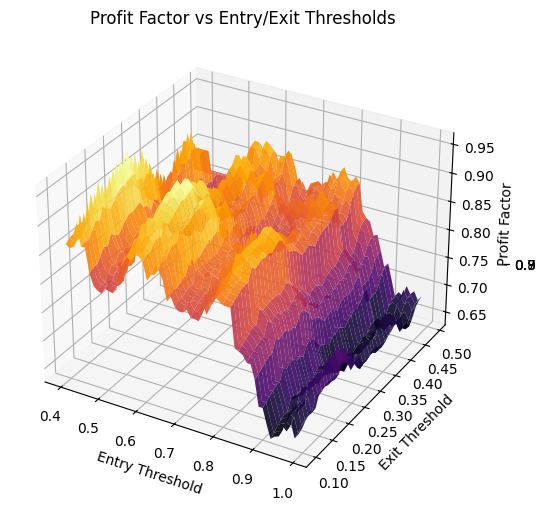

In [143]:
create_surface_plots(
    df=performance_metrics_grid.drop_duplicates(),
    values=["Profit Factor"],
    cmap="inferno"
)

plt.show()

In [138]:
# entry_thresh, exit_thresh = performance_metrics_grid[performance_metrics_grid["Avg Loss"]==performance_metrics_grid["Avg Loss"].max()].head(1).values[0][:2]

# entry_thresh, exit_thresh

In [144]:
entry_thresh, exit_thresh = performance_metrics_grid[performance_metrics_grid["Profit Factor"]==performance_metrics_grid["Profit Factor"].max()].head(1).values[0][:2]

entry_thresh, exit_thresh

(np.float64(0.43), np.float64(0.24))

In [147]:
test_rolling_params = get_rolling_signals(
        prices=pd.concat(
            [
                train_df[indic].set_index(train_index[indic]), 
                val_df[indic].set_index(val_index[indic]), 
                test_df[indic].set_index(test_index[indic])
            ], 
            axis=0
        ),
        select_pairs=final_pairs, 
        rolling_window=5
    )

test_positions = get_long_short_signals(
    prices=test_df[indic].set_index(test_index[indic]),
    select_pairs=final_pairs,
    rolling_params=test_rolling_params,
    entry_threshold=entry_thresh,
    exit_threshold=exit_thresh
)

test_returns = test_positions.shift(+1) * test_df[indic].set_index(test_index[indic])[test_positions.columns].pct_change()

test_pair_wise_returns = pd.concat(
    [test_returns[pair].sum(axis=1).rename("_".join(pair)) for pair in final_pairs], 
    axis=1
)

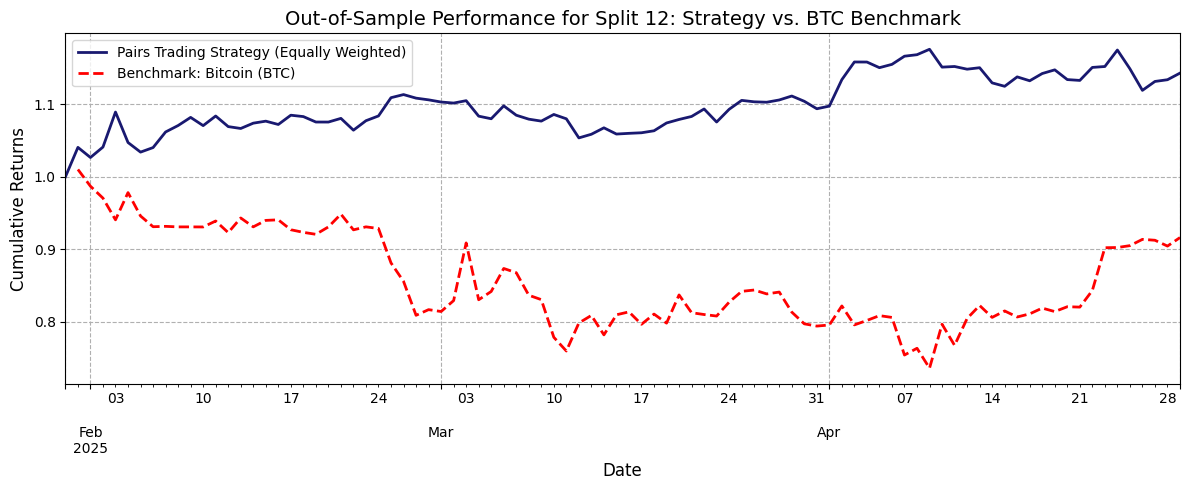

In [148]:
plt.figure(figsize=(12, 5))

# Plot strategy cumulative return
(1 + test_pair_wise_returns.mean(axis=1)).cumprod().plot(
    label="Pairs Trading Strategy (Equally Weighted)",
    color="midnightblue",
    linewidth=2
)

# Plot benchmark cumulative return
(1 + test_df[indic].set_index(test_index[indic])["BTC"].pct_change()).cumprod().plot(
    label="Benchmark: Bitcoin (BTC)",
    color="red",
    linestyle="--",
    linewidth=2
)

plt.ylabel("Cumulative Returns", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.title(f"Out-of-Sample Performance for Split {indic+1}: Strategy vs. BTC Benchmark", fontsize=14)
plt.grid(True, linestyle="--")
plt.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

In [149]:
from IPython.display import display, Markdown

display(Markdown("### Out-of-Sample (Test Set) Performance Metrics:"))

display(pd.DataFrame(
    compute_performance_metrics(
        strategy_returns=test_pair_wise_returns.mean(axis=1),
        benchmark_returns=test_df[indic].set_index(test_index[indic])["BTC"]
    )
).T)


### Out-of-Sample (Test Set) Performance Metrics:

,Holding Period (Days),Holding Period (Months),Holding Period (Years),Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Win Rate,Avg Win,Avg Loss,Profit Factor,Alpha,Beta,R-squared
0,90.0,4.29,0.36,0.143243,0.454748,0.211023,1.881544,2.867821,-0.053715,0.555556,0.010096,-0.009308,1.390636,-3.477666,1.725029e-07,0.007779


In [153]:
pair_wise_returns

,BTCB_BTC.B,PAXG_XAUT,ENJ_LRC,KSM_WOO,FET_SHIB,DOGE_SHIB,STX_PROM,GRT_XYO,DOGE_AIOZ,CELO_WIN,...,AR_AIOZ,AR_DEXE,ALGO_AXS,RENDER_NEXO,THETA_ANKR,STX_SUPER,ETH_NEXO,BTCB_WSTETH,FLOKI_AR,SUPER_AKT
split_11,,,,,,,,,,,,,,,,,,,,,
2024-08-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-04,0.000000,0.000000,-0.013890,0.033497,-0.039495,0.052915,0.023387,-0.136457,0.106213,-0.034334,...,0.079825,0.045894,-0.010946,0.017059,0.013917,0.000000,-0.010835,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.008098,-0.006894,0.021236,-0.005632,0.024168,0.000000,-0.066661,0.030537,-0.048375,...,-0.005567,-0.042037,0.000000,0.065700,-0.005321,0.000000,-0.007835,0.000000,-0.078954,0.000000
2024-08-06,0.007506,0.000000,-0.030863,-0.038808,-0.140002,0.001135,-0.172376,-0.004316,0.081217,-0.011069,...,0.011878,0.020454,0.000000,-0.055051,-0.021995,0.069904,-0.071194,0.038673,-0.069339,0.164628
2024-08-07,0.065912,0.000000,-0.034024,-0.001144,0.054299,-0.011558,0.103451,-0.025025,-0.211522,0.008568,...,-0.158167,0.028985,0.000000,0.067917,-0.013753,-0.060634,-0.040689,0.015431,-0.044248,0.074456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004814,-0.041369,-0.069778,-0.002477,0.000000,...,0.049106,0.046769,-0.004435,0.017721,0.000000,-0.087073,-0.008629,0.000000,0.015952,-0.044589
2025-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017215,-0.095221,0.021253,0.040353,...,0.034402,-0.037607,0.000000,0.000000,0.019666,-0.017477,0.000000,0.000000,0.013149,-0.000263
2025-01-27,-0.000336,0.000000,0.026820,0.000000,-0.021977,0.000000,0.043842,0.199409,0.000000,0.000000,...,0.000000,0.000000,-0.022468,-0.034179,0.000000,0.084233,0.000000,-0.019201,0.000000,0.028251
